# 9. Neural Network Classification

Let's now build a neural network classification model.

### Load the modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import h5py
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Check whether GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Hide warnings

In [3]:
# Hide warnings (to keep notebook tidy)
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set seeds to make results reproducible
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

### Load dataset

In [5]:
# Read in dataset
devon_cornwall_lsoa = pd.read_csv('./data/dandc_crime_and_demographics.csv')
# Drop LSOA code 
devon_cornwall = devon_cornwall_lsoa.drop('lsoa_code', axis=1)
# Make data float type
devon_cornwall = devon_cornwall.astype(float)

## Total crime
As ever, let's build our first model for predicting total crime.

### Prepare labels

We are now looking to classify our data as one of a number of labels. Let's try to predict the areas with the highest crime. We will label the top decile 1, and the rest 0.

We will need to do some more processing of the data to create these labels:

In [6]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['crime_total'], bin_edges = pd.qcut(devon_cornwall['crime_total'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [7]:
# Have a look at counts
devon_cornwall['crime_total'].value_counts()

0    930
1    104
Name: crime_total, dtype: int64

In [8]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0       47.0     0
1      819.7     1

### Divide into features (X) and labels (y)

We will split into features (X) and labels (y) and convert these from pandas dataframes to NumPy arrays. These are simpler to refer to by row/column index numbers, which we will use for sklearn's k-fold method.

In [9]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['crime_total'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

### Encode labels

In [10]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

### Scale the data

Now we will write a function for scaling the input data from 0 to 1.

In [11]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

### Build model based on a neural network

Let's build a sequential neural network model.

In [12]:
# Define function to train and apply regularised neural network
def neural_net(X,y):
    
    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                save_best_only=True)
    
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                  restore_best_weights=True)
        
    # Set up list to hold history for each k-fold run
    histories = []
    # Set up splits
    number_of_splits = 10
    seed = 42
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    skf.get_n_splits(X, y)
    # Loop through the k-fold splits
    k_fold_count = 1
    for train_index, test_index in skf.split(X, y):
    
        print(f"\nFold number {k_fold_count}")
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Standardise X data
        X_train_sc, X_test_sc = scale_data(X_train, X_test) 
        # Set up and fit model
        

        model = Sequential()
        model.add(Dense(128, input_dim=X_train_sc.shape[1], activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation = 'sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    
        history = model.fit(X_train_sc,
                            y_train,validation_data=(X_test_sc,y_test),
                            verbose=0,epochs=1000, 
                            batch_size=32,
                            callbacks=[checkpoint_cb, early_stopping_cb])
        
        histories.append(history)
        
    
        k_fold_count +=1
        
    return histories

In [13]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [14]:
# Define function for plotting accuracy
def plot_accuracy(histories):
    for history in histories:
        plt.plot(history.history['accuracy'], label='train', color='green')
        plt.plot(history.history['val_accuracy'], label='test', color='red')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
    plt.legend(['train','test'])
    plt.show()

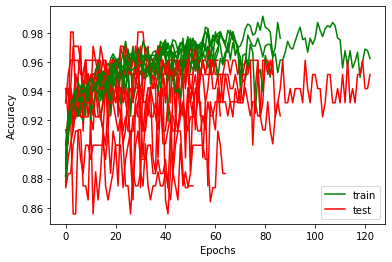

In [15]:
plot_accuracy(histories)

In [16]:
# Define function for plotting mean accuracy
def plot_mean_accuracy(histories):
    
    # Create lists of mean training and test RMSEs
    train_acc = []
    test_acc = []

    for history in histories:
        train_acc.append(history.history['accuracy'])
        test_acc.append(history.history['val_accuracy'])
    
    # Calculate mean training accuracy by epoch
    length = max(map(len, train_acc))
    train_acc=np.array([history+[None]*(length-len(history)) for history in train_acc], dtype=float)
    mean_train_acc = np.nanmean(train_acc, axis=0)
    
    # Calculate mean test accuracy by epoch
    length = max(map(len, test_acc))
    test_acc=np.array([history+[None]*(length-len(history)) for history in test_acc], dtype=float)
    mean_test_acc = np.nanmean(test_acc, axis=0)
    
    # Plot mean accuracy by epoch
    plt.plot(mean_train_acc, label='train', color='green')
    plt.plot(mean_test_acc, label='test', color='red')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train','test'])
    plt.show()

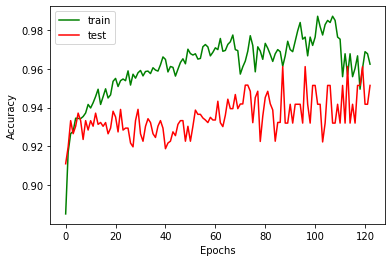

In [17]:
plot_mean_accuracy(histories)

In [18]:
# Define function for calculating mean final accuracy
def mean_accuracy(histories):
    training_accuracy_results = []
    test_accuracy_results = []
    for history in histories:
        accuracy_train = history.history['accuracy'][-1]
        accuracy_test = history.history['val_accuracy'][-1]
        training_accuracy_results.append(accuracy_train)
        test_accuracy_results.append(accuracy_test)
    mean_training = np.mean(training_accuracy_results)
    mean_test = np.mean(test_accuracy_results) 
    print('Mean training accuracy: ',mean_training)
    print('Mean test accuracy: ',mean_test)

In [19]:
mean_accuracy(histories)

Mean training accuracy:  0.9695912659168243
Mean test accuracy:  0.930414491891861


### Dealing with imbalanced data

Our data is highly imbalanced, so the model may end up biased towards the majority class and under-predicting the minority class. Let's try changing the probability thresholds to deal with this. 

In [20]:
# Define function to calculate various accuracy measurements
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

In [21]:
# Define function to check and plot different probability thresholds
def check_thresholds(X,y):    

    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                    save_best_only=True)

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                      restore_best_weights=True)
    # Set up splits
    number_of_splits = 10
    seed = 42
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    skf.get_n_splits(X, y)

    # Set up thresholds
    thresholds = np.arange(0, 1.01, 0.01)

    # Create arrays for overall results (rows=threshold, columns=k fold replicate)
    results_accuracy = np.zeros((len(thresholds),number_of_splits))
    results_precision = np.zeros((len(thresholds),number_of_splits))
    results_recall = np.zeros((len(thresholds),number_of_splits))
    results_f1 = np.zeros((len(thresholds),number_of_splits))
    results_predicted_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_observed_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_true_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_false_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_auc = []

    # Loop through the k-fold splits
    loop_index = 0
    for train_index, test_index in skf.split(X, y):

        # Create lists for k-fold results
        threshold_accuracy = []
        threshold_precision = []
        threshold_recall = []
        threshold_f1 = []
        threshold_predicted_positive_rate = []
        threshold_observed_positive_rate = []
        threshold_true_positive_rate = []
        threshold_false_positive_rate = []

        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale data
        X_train_sc, X_test_sc = scale_data(X_train, X_test)

        # Set up and fit model 
        model = Sequential()
        model.add(Dense(128, input_dim=X_train_sc.shape[1], activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation = 'sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

        model.fit(X_train_sc,
                  y_train,validation_data=(X_test_sc,y_test),
                  verbose=0,epochs=1000, 
                  batch_size=32,
                  callbacks=[checkpoint_cb, early_stopping_cb])


        # Get probability of high crime
        probability_high_crime = model.predict(X_test_sc)
        probability_high_crime = probability_high_crime.flatten()

        # Loop through increments in probability of high crime
        for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
            # Get whether high crime using cutoff
            predicted_high_crime = probability_high_crime >= cutoff
            # Call accuracy measures function
            accuracy = calculate_accuracy(y_test, predicted_high_crime)
            # Add accuracy scores to lists
            threshold_accuracy.append(accuracy['accuracy'])
            threshold_precision.append(accuracy['precision'])
            threshold_recall.append(accuracy['recall'])
            threshold_f1.append(accuracy['f1'])
            threshold_predicted_positive_rate.append(
                    accuracy['predicted_positive_rate'])
            threshold_observed_positive_rate.append(
                    accuracy['observed_positive_rate'])
            threshold_true_positive_rate.append(accuracy['true_positive_rate'])
            threshold_false_positive_rate.append(accuracy['false_positive_rate'])

        # Add results to results arrays
        results_accuracy[:,loop_index] = threshold_accuracy
        results_precision[:, loop_index] = threshold_precision
        results_recall[:, loop_index] = threshold_recall
        results_f1[:, loop_index] = threshold_f1
        results_predicted_positive_rate[:, loop_index] = \
            threshold_predicted_positive_rate
        results_observed_positive_rate[:, loop_index] = \
            threshold_observed_positive_rate
        results_true_positive_rate[:, loop_index] = threshold_true_positive_rate
        results_false_positive_rate[:, loop_index] = threshold_false_positive_rate

        # Calculate ROC AUC
        roc_auc = auc(threshold_false_positive_rate, threshold_true_positive_rate)
        results_auc.append(roc_auc)

        # Increment loop index
        loop_index += 1


    # Transfer summary results to dataframe
    results = pd.DataFrame(thresholds, columns=['thresholds'])
    results['accuracy'] = results_accuracy.mean(axis=1)
    results['precision'] = results_precision.mean(axis=1)
    results['recall'] = results_recall.mean(axis=1)
    results['f1'] = results_f1.mean(axis=1)
    results['predicted_positive_rate'] = \
        results_predicted_positive_rate.mean(axis=1)
    results['observed_positive_rate'] = \
        results_observed_positive_rate.mean(axis=1)
    results['true_positive_rate'] = results_true_positive_rate.mean(axis=1)
    results['false_positive_rate'] = results_false_positive_rate.mean(axis=1)
    results['roc_auc'] = np.mean(results_auc)

    mean_auc = np.mean(results_auc)
    mean_auc = np.round(mean_auc, 3)
    
    # Plot ROC curve

    %matplotlib inline

    for i in range(number_of_splits):
        plt.plot(results_false_positive_rate[:, i],
                 results_true_positive_rate[:, i],
                 color='black',
                 linestyle=':',
                 linewidth=1)
    plt.plot(results_false_positive_rate.mean(axis=1),
             results_true_positive_rate.mean(axis=1),
             color='red',
             linestyle='-',
             linewidth=2)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operator Characteristic (ROC) Curve')
    plt.grid(True)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    text = "Mean AUC = " + str(mean_auc)
    plt.text(0.65, 0.08, text, bbox=props)
    plt.show()
    
    return results

In [22]:
results = check_thresholds(X,y)

In [23]:
# Define function to plot effects of changing classification probability threshold
def plot_thresholds(results):
    chart_x = results['thresholds']

    plt.plot(chart_x, results['accuracy'],
             linestyle = '-',
             label = 'Accuracy')

    plt.plot(chart_x, results['precision'],
             linestyle = '--',
             label = 'Precision')

    plt.plot(chart_x, results['recall'],
             linestyle = '-.',
             label = 'Recall')

    plt.plot(chart_x, results['f1'],
             linestyle = ':',
             label = 'F1')

    plt.plot(chart_x, results['predicted_positive_rate'],
             linestyle = '-',
             label = 'Predicted positive rate')

    plt.plot(chart_x, results['observed_positive_rate'],
             linestyle = '--',
             color='k',
             label = 'Observed positive rate')


    plt.xlabel('Probability cutoff for classification')
    plt.ylabel('Score')
    plt.ylim(-0.02, 1.02)
    plt.legend(loc='center right')
    plt.grid(True)

    plt.show()

In [24]:
plot_thresholds(results)

In [25]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.32,0.34])])

    thresholds  accuracy  precision    recall        f1  \
32        0.32  0.937192   0.696174  0.712727  0.697552   
34        0.34  0.938144   0.702341  0.692727  0.691582   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
32                 0.105377                 0.10056            0.712727   
34                 0.100541                 0.10056            0.692727   

    false_positive_rate   roc_auc  
32             0.037634  0.952478  
34             0.034409  0.952478  


A probability threshold of about 0.33 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [26]:
threshold = 0.33

In [27]:
# Define function to apply final model with selected thresholds
def final_neural_network(X, y):    
    
    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                    monitor="loss",
                                                    save_best_only=True)

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=50,
                                                      monitor="loss",
                                                      restore_best_weights=True)


    # Scale data
    sc = MinMaxScaler()
    sc.fit(X)
    X_sc = sc.transform(X)

    # Set up and fit model with best parameters
    model = Sequential()
    model.add(Dense(128, input_dim=X_sc.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

    history = model.fit(X_sc,y,
                        verbose=0,epochs=1000, 
                        batch_size=32,
                        callbacks=[checkpoint_cb, early_stopping_cb])
    
    # Plot history
    plt.plot(history.history['accuracy'], label='accuracy', color='green')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train','test'])
    plt.show()

    # Get probability of high crime
    probability_high_crime = model.predict(X_sc)
    probability_high_crime = probability_high_crime.flatten()

    # Get whether high crime using cutoff
    predicted_high_crime = probability_high_crime >= threshold
    
    # Create dataframe of actual and predicted crime
    d = {'actual': y,
    'predicted': predicted_high_crime*1}
    results = pd.DataFrame(d)
    
    return results

In [28]:
predictions = final_neural_network(X, y)

In [29]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [30]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_total.csv')

## Antisocial behaviour

Now we will build random forest models for all the different crime types. 

In [31]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['antisocial'], bin_edges = pd.qcut(devon_cornwall['antisocial'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [32]:
# Have a look at counts
devon_cornwall['antisocial'].value_counts()

0    930
1    104
Name: antisocial, dtype: int64

In [33]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        7.0     0
1      244.7     1

In [34]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['antisocial'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [35]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [36]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [37]:
plot_accuracy(histories)

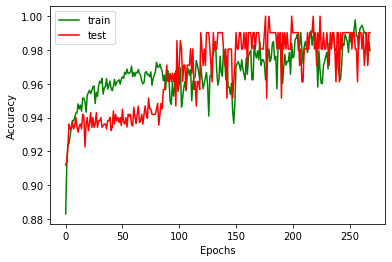

In [38]:
plot_mean_accuracy(histories)

In [39]:
mean_accuracy(histories)

Mean training accuracy:  0.9640012383460999
Mean test accuracy:  0.9400765478610993


In [40]:
results = check_thresholds(X,y)

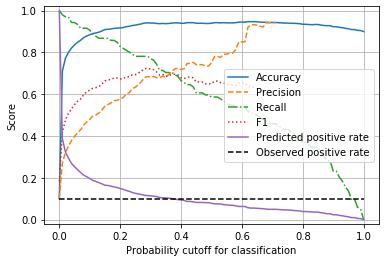

In [41]:
plot_thresholds(results)

In [42]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.36, 0.38])])

    thresholds  accuracy  precision    recall        f1  \
36        0.36  0.938153   0.694336  0.703636  0.688565   
38        0.38  0.941029   0.721577  0.693636  0.695063   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
36                 0.102493                 0.10056            0.703636   
38                 0.097676                 0.10056            0.693636   

    false_positive_rate   roc_auc  
36             0.035484  0.952561  
38             0.031183  0.952561  


A probability threshold of about 0.37 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [43]:
threshold = 0.37

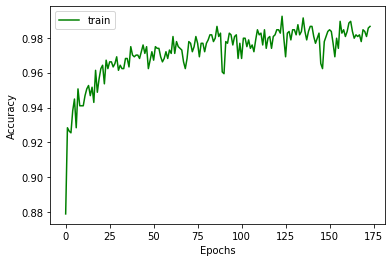

In [44]:
predictions = final_neural_network(X, y)

In [45]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [46]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_antisocial.csv')

## Bike theft

In [47]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['bike_theft'], bin_edges = pd.qcut(devon_cornwall['bike_theft'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [48]:
# Have a look at counts
devon_cornwall['bike_theft'].value_counts()

0    933
1    101
Name: bike_theft, dtype: int64

In [49]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        6.0     1

In [50]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['bike_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [51]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [52]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


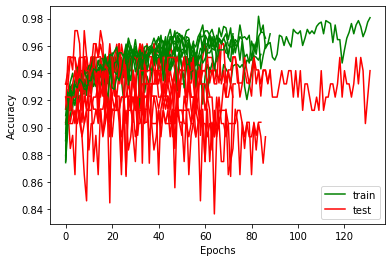

In [53]:
plot_accuracy(histories)

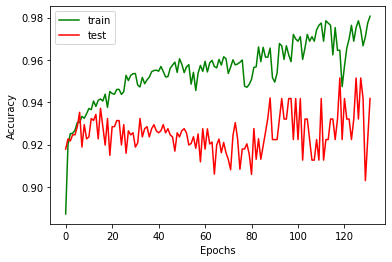

In [54]:
plot_mean_accuracy(histories)

In [55]:
mean_accuracy(histories)

Mean training accuracy:  0.9629257559776306
Mean test accuracy:  0.9216672837734222


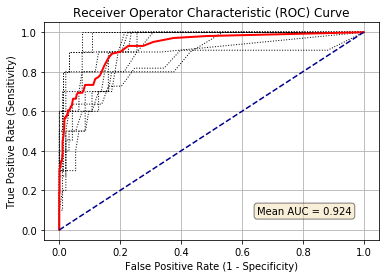

In [56]:
results = check_thresholds(X,y)

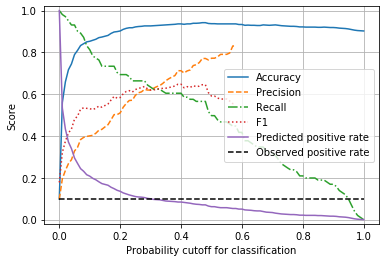

In [57]:
plot_thresholds(results)

In [58]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.3,0.32])])

    thresholds  accuracy  precision    recall        f1  \
30        0.30  0.926494   0.619742  0.633636  0.619731   
32        0.32  0.928426   0.635861  0.623636  0.623919   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
30                 0.099599                0.097676            0.633636   
32                 0.095724                0.097676            0.623636   

    false_positive_rate   roc_auc  
30             0.041810  0.924025  
32             0.038595  0.924025  


A probability threshold of about 0.31 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [59]:
threshold = 0.31

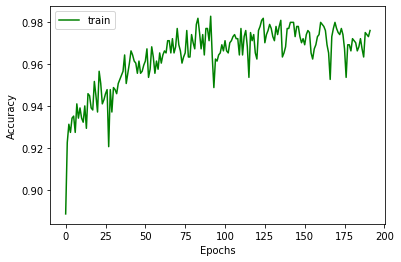

In [60]:
predictions = final_neural_network(X, y)

In [61]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [62]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_bike_theft.csv')

## Burglary

In [63]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['burglary'], bin_edges = pd.qcut(devon_cornwall['burglary'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [64]:
# Have a look at counts
devon_cornwall['burglary'].value_counts()

0    930
1    104
Name: burglary, dtype: int64

In [65]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       33.7     1

In [66]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['burglary'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [67]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [68]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


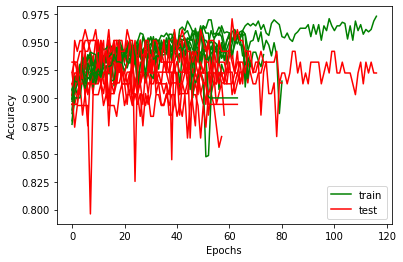

In [69]:
plot_accuracy(histories)

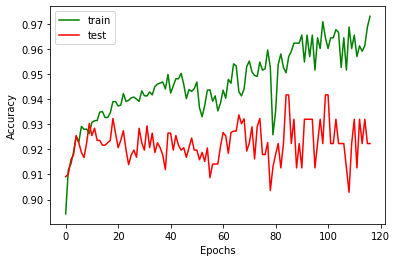

In [70]:
plot_mean_accuracy(histories)

In [71]:
mean_accuracy(histories)

Mean training accuracy:  0.934229701757431
Mean test accuracy:  0.9111090362071991


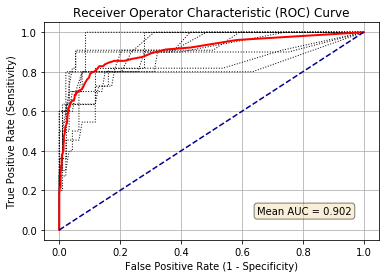

In [72]:
results = check_thresholds(X,y)

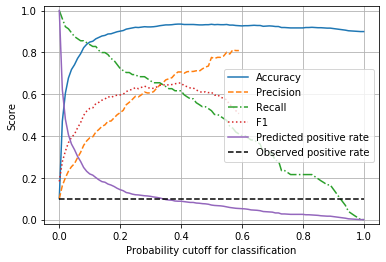

In [73]:
plot_thresholds(results)

In [74]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.32,0.34,0.36])])

    thresholds  accuracy  precision    recall        f1  \
32        0.32  0.924571   0.628947  0.654545  0.634332   
34        0.34  0.929406   0.653372  0.645455  0.642580   
36        0.36  0.931348   0.673535  0.626364  0.643337   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
32                 0.106385                 0.10056            0.654545   
34                 0.099627                 0.10056            0.645455   
36                 0.093820                 0.10056            0.626364   

    false_positive_rate   roc_auc  
32             0.045161  0.901857  
34             0.038710  0.901857  
36             0.034409  0.901857  


A probability threshold of about 0.34 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [75]:
threshold = 0.34

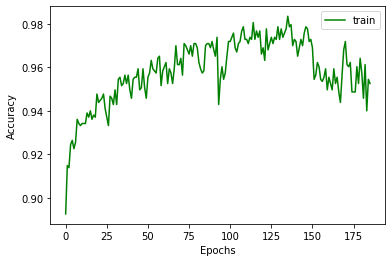

In [76]:
predictions = final_neural_network(X, y)

In [77]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [78]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_burglary.csv')

## Criminal damage and arson

In [79]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['damage_arson'], bin_edges = pd.qcut(devon_cornwall['damage_arson'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [80]:
# Have a look at counts
devon_cornwall['damage_arson'].value_counts()

0    931
1    103
Name: damage_arson, dtype: int64

In [81]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        1.0     0
1       88.0     1

In [82]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['damage_arson'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [83]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [84]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


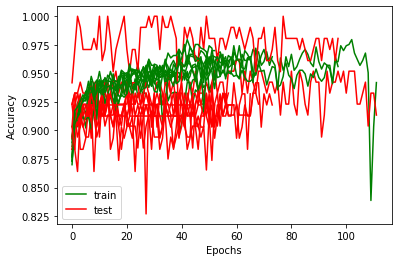

In [85]:
plot_accuracy(histories)

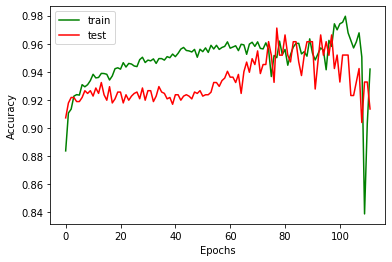

In [86]:
plot_mean_accuracy(histories)

In [87]:
mean_accuracy(histories)

Mean training accuracy:  0.9559401929378509
Mean test accuracy:  0.9265309929847717


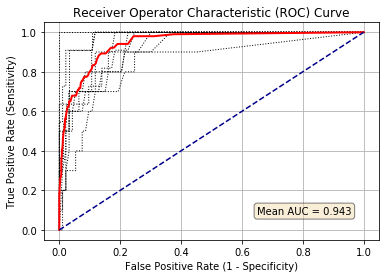

In [88]:
results = check_thresholds(X,y)

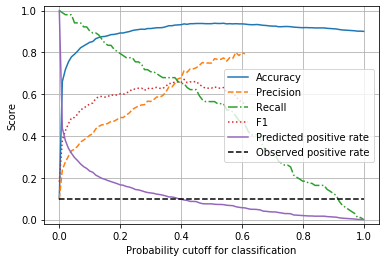

In [89]:
plot_thresholds(results)

In [90]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.38,0.4])])

    thresholds  accuracy  precision    recall        f1  \
38        0.38  0.930302   0.652078  0.679091  0.659365   
40        0.40  0.932254   0.678113  0.650909  0.656155   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
38                 0.105461                0.099599            0.679091   
40                 0.097741                0.099599            0.650909   

    false_positive_rate   roc_auc  
38             0.041901  0.942958  
40             0.036525  0.942958  


A probability threshold of about 0.39 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [91]:
threshold = 0.39

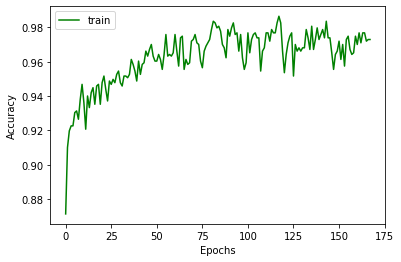

In [92]:
predictions = final_neural_network(X, y)

In [93]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [94]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_damage_arson.csv')

## Drugs

In [95]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['drugs'], bin_edges = pd.qcut(devon_cornwall['drugs'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [96]:
# Have a look at counts
devon_cornwall['drugs'].value_counts()

0    930
1    104
Name: drugs, dtype: int64

In [97]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       24.7     1

In [98]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['drugs'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [99]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [100]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [101]:
plot_accuracy(histories)

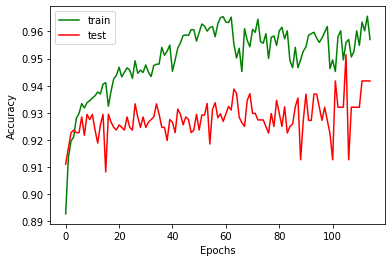

In [102]:
plot_mean_accuracy(histories)

In [103]:
mean_accuracy(histories)

Mean training accuracy:  0.9542248368263244
Mean test accuracy:  0.9265123248100281


In [104]:
results = check_thresholds(X,y)

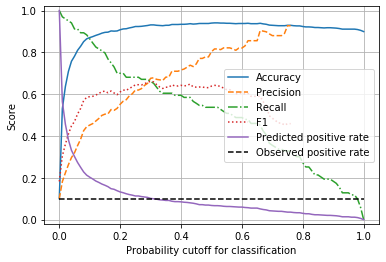

In [105]:
plot_thresholds(results)

In [106]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.28,0.3])])

    thresholds  accuracy  precision    recall        f1  \
28        0.28  0.926531   0.641908  0.670909  0.650470   
30        0.30  0.931348   0.675983  0.660909  0.662146   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
28                 0.108234                 0.10056            0.670909   
30                 0.101475                 0.10056            0.660909   

    false_positive_rate   roc_auc  
28             0.045161  0.924995  
30             0.038710  0.924995  


A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [107]:
threshold = 0.3

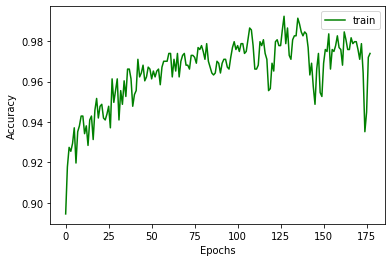

In [108]:
predictions = final_neural_network(X, y)

In [109]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [110]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_drugs.csv')

## Other crime

In [111]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['other_crime'], bin_edges = pd.qcut(devon_cornwall['other_crime'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [112]:
# Have a look at counts
devon_cornwall['other_crime'].value_counts()

0    934
1    100
Name: other_crime, dtype: int64

In [113]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       13.0     1

In [114]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [115]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [116]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


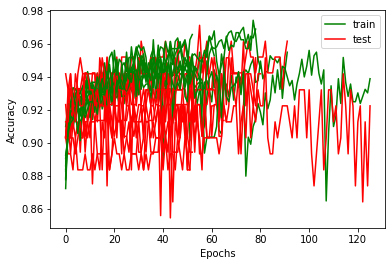

In [117]:
plot_accuracy(histories)

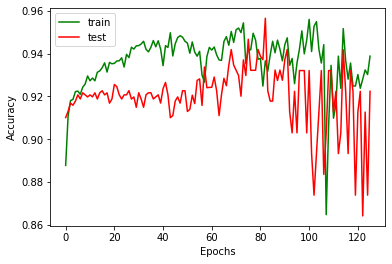

In [118]:
plot_mean_accuracy(histories)

In [119]:
mean_accuracy(histories)

Mean training accuracy:  0.9511078357696533
Mean test accuracy:  0.9207057476043701


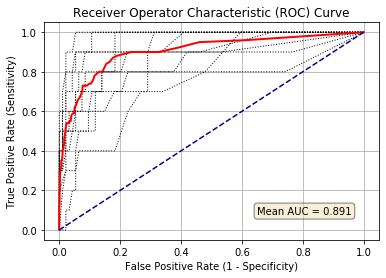

In [120]:
results = check_thresholds(X,y)

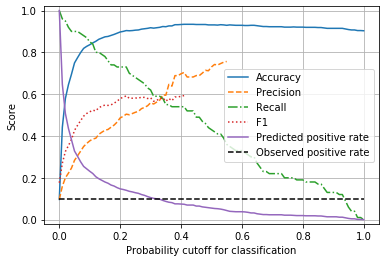

In [121]:
plot_thresholds(results)

In [122]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.34,0.36])])

    thresholds  accuracy  precision  recall        f1  \
34        0.34  0.923572   0.596579    0.58  0.583679   
36        0.36  0.926484   0.646796    0.55  0.579344   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
34                 0.091888                0.096714                0.58   
36                 0.083168                0.096714                0.55   

    false_positive_rate   roc_auc  
34             0.039636  0.890836  
36             0.033196  0.890836  


A probability threshold of about 0.34 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [123]:
threshold = 0.34

In [124]:
predictions = final_neural_network(X, y)

In [125]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       1          1
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [126]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_other_crime.csv')

## Other theft

In [127]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['other_theft'], bin_edges = pd.qcut(devon_cornwall['other_theft'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [128]:
# Have a look at counts
devon_cornwall['other_theft'].value_counts()

0    930
1    104
Name: other_theft, dtype: int64

In [129]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        1.0     0
1       62.7     1

In [130]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [131]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [132]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


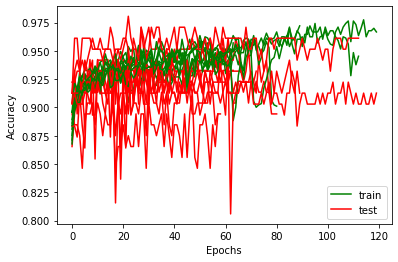

In [133]:
plot_accuracy(histories)

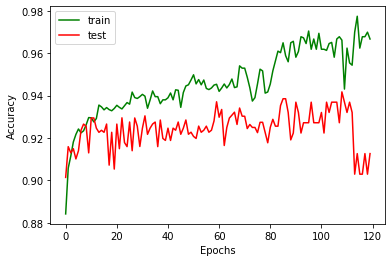

In [134]:
plot_mean_accuracy(histories)

In [135]:
mean_accuracy(histories)

Mean training accuracy:  0.948954051733017
Mean test accuracy:  0.9188200235366821


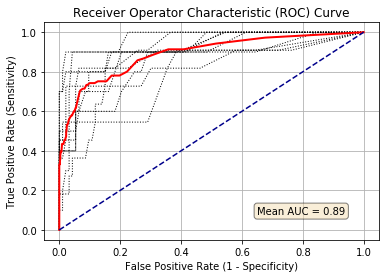

In [136]:
results = check_thresholds(X,y)

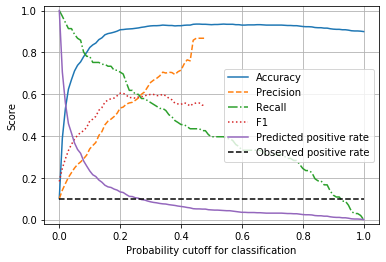

In [137]:
plot_thresholds(results)

In [138]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.24,0.26])])

    thresholds  accuracy  precision    recall        f1  \
24        0.24  0.912995   0.561098  0.618182  0.584685   
26        0.26  0.916869   0.581818  0.599091  0.586520   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
24                 0.110269                 0.10056            0.618182   
26                 0.102530                 0.10056            0.599091   

    false_positive_rate   roc_auc  
24             0.053763  0.889922  
26             0.047312  0.889922  


A probability threshold of about 0.26 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [139]:
threshold = 0.26

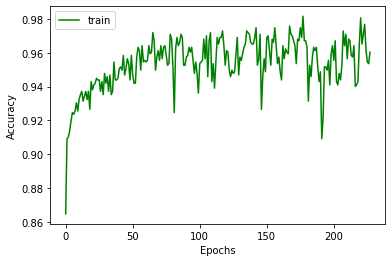

In [140]:
predictions = final_neural_network(X, y)

In [141]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [142]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_other_theft.csv')

## Possession of weapons

In [143]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['possession_weapons'], bin_edges = pd.qcut(devon_cornwall['possession_weapons'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [144]:
# Have a look at counts
devon_cornwall['possession_weapons'].value_counts()

0    941
1     93
Name: possession_weapons, dtype: int64

In [145]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        6.0     1

In [146]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['possession_weapons'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [147]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [148]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


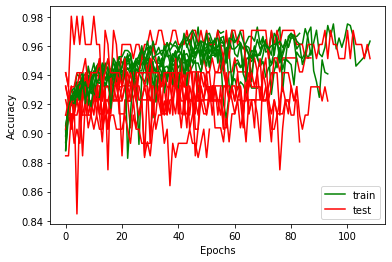

In [149]:
plot_accuracy(histories)

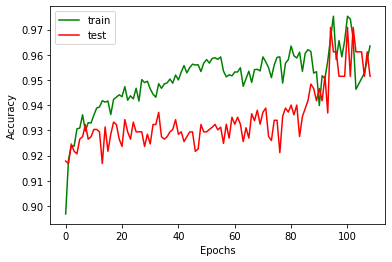

In [150]:
plot_mean_accuracy(histories)

In [151]:
mean_accuracy(histories)

Mean training accuracy:  0.9544367790222168
Mean test accuracy:  0.9264936566352844


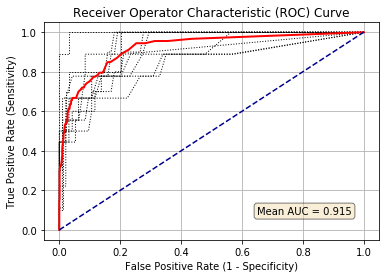

In [152]:
results = check_thresholds(X,y)

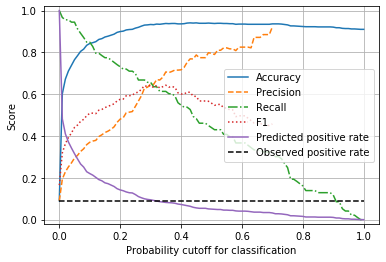

In [153]:
plot_thresholds(results)

In [154]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'] == 0.3])

    thresholds  accuracy  precision    recall        f1  \
30         0.3  0.933336   0.648484  0.656667  0.642504   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
30                 0.094716                0.089927            0.656667   

    false_positive_rate   roc_auc  
30             0.039295  0.915226  


A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [155]:
threshold = 0.3

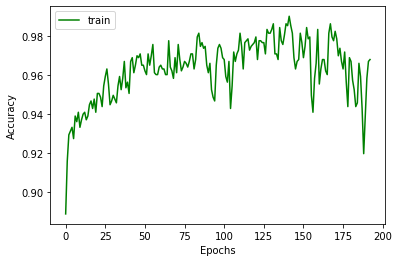

In [156]:
predictions = final_neural_network(X, y)

In [157]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [158]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_possession_weapons.csv')

## Public order offences

In [159]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['public_order'], bin_edges = pd.qcut(devon_cornwall['public_order'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [160]:
# Have a look at counts
devon_cornwall['public_order'].value_counts()

0    932
1    102
Name: public_order, dtype: int64

In [161]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       40.0     1

In [162]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['public_order'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [163]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [164]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [165]:
plot_accuracy(histories)

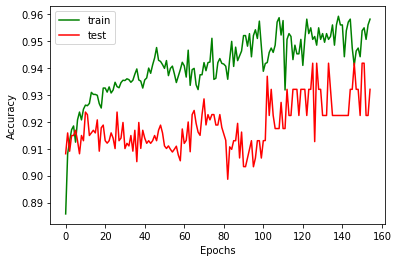

In [166]:
plot_mean_accuracy(histories)

In [167]:
mean_accuracy(histories)

Mean training accuracy:  0.9383154928684234
Mean test accuracy:  0.912994772195816


In [168]:
results = check_thresholds(X,y)

In [169]:
plot_thresholds(results)

In [170]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'] == 0.3])

    thresholds  accuracy  precision    recall        f1  \
30         0.3  0.905218   0.524679  0.537273  0.520185   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
30                 0.102511                0.098637            0.537273   

    false_positive_rate   roc_auc  
30             0.054713  0.912036  


A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [171]:
threshold = 0.3

In [172]:
predictions = final_neural_network(X, y)

In [173]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [174]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_public_order.csv')

## Robbery

In [175]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['robbery'], bin_edges = pd.qcut(devon_cornwall['robbery'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [176]:
# Have a look at counts
devon_cornwall['robbery'].value_counts()

0    941
1     93
Name: robbery, dtype: int64

In [177]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        4.0     1

In [178]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['robbery'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [179]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [180]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [181]:
plot_accuracy(histories)

In [182]:
plot_mean_accuracy(histories)

In [183]:
mean_accuracy(histories)

Mean training accuracy:  0.971631383895874
Mean test accuracy:  0.9371265828609466


In [184]:
results = check_thresholds(X,y)

In [185]:
plot_thresholds(results)

In [186]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.36,0.38])])

    thresholds  accuracy  precision    recall        f1  \
36        0.36  0.942924   0.693838  0.688889  0.687736   
38        0.38  0.942914   0.701775  0.677778  0.684477   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
36                 0.090935                0.089927            0.688889   
38                 0.089003                0.089927            0.677778   

    false_positive_rate   roc_auc  
36             0.031892  0.933045  
38             0.030829  0.933045  


A probability threshold of about 0.36 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [187]:
threshold = 0.36

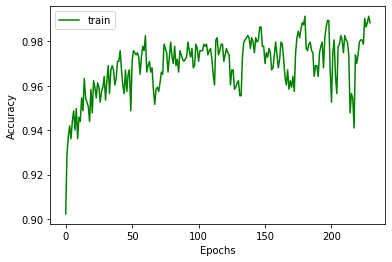

In [188]:
predictions = final_neural_network(X, y)

In [189]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       1          1
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [190]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_robbery.csv')

## Shoplifting

In [191]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['shoplifting'], bin_edges = pd.qcut(devon_cornwall['shoplifting'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [192]:
# Have a look at counts
devon_cornwall['shoplifting'].value_counts()

0    930
1    104
Name: shoplifting, dtype: int64

In [193]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       58.7     1

In [194]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['shoplifting'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [195]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [196]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


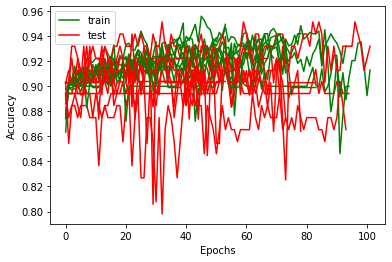

In [197]:
plot_accuracy(histories)

In [198]:
plot_mean_accuracy(histories)

In [199]:
mean_accuracy(histories)

Mean training accuracy:  0.9222014725208283
Mean test accuracy:  0.8974981427192688


In [200]:
results = check_thresholds(X,y)

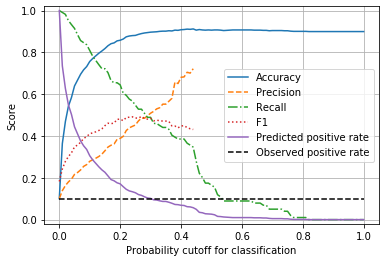

In [201]:
plot_thresholds(results)

In [202]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'] == 0.28])

    thresholds  accuracy  precision    recall        f1  \
28        0.28    0.8927   0.484611  0.508182  0.484813   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
28                 0.109205                 0.10056            0.508182   

    false_positive_rate   roc_auc  
28             0.064516  0.859022  


A probability threshold of about 0.28 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [203]:
threshold = 0.28

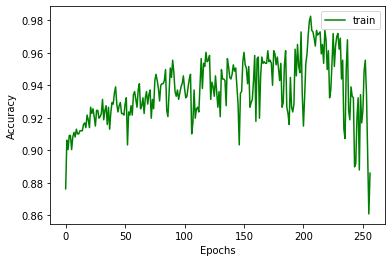

In [204]:
predictions = final_neural_network(X, y)

In [205]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [206]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_shoplifting.csv')

## Theft from the person

In [207]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['theft_person'], bin_edges = pd.qcut(devon_cornwall['theft_person'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [208]:
# Have a look at counts
devon_cornwall['theft_person'].value_counts()

0    934
1    100
Name: theft_person, dtype: int64

In [209]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        5.0     1

In [210]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['theft_person'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [211]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [212]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [213]:
plot_accuracy(histories)

In [214]:
plot_mean_accuracy(histories)

In [215]:
mean_accuracy(histories)

Mean training accuracy:  0.9569101333618164
Mean test accuracy:  0.9303584694862366


In [216]:
results = check_thresholds(X,y)

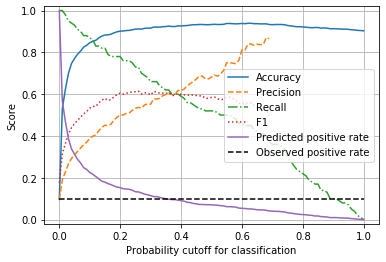

In [217]:
plot_thresholds(results)

In [218]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.36,0.38])])

    thresholds  accuracy  precision  recall        f1  \
36        0.36  0.925523   0.606483    0.62  0.608118   
38        0.38  0.923590   0.598402    0.60  0.594083   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
36                 0.097685                0.096714                0.62   
38                 0.095752                0.096714                0.60   

    false_positive_rate   roc_auc  
36             0.041764  0.923833  
38             0.041764  0.923833  


A probability threshold of about 0.38 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [219]:
threshold = 0.38

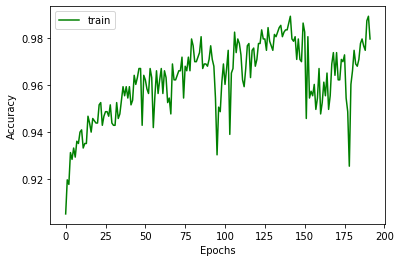

In [220]:
predictions = final_neural_network(X, y)

In [221]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       0          0
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [222]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_theft_person.csv')

## Vehicle crime

In [223]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['vehicle_crime'], bin_edges = pd.qcut(devon_cornwall['vehicle_crime'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [224]:
# Have a look at counts
devon_cornwall['vehicle_crime'].value_counts()

0    932
1    102
Name: vehicle_crime, dtype: int64

In [225]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       31.0     1

In [226]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['vehicle_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [227]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [228]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


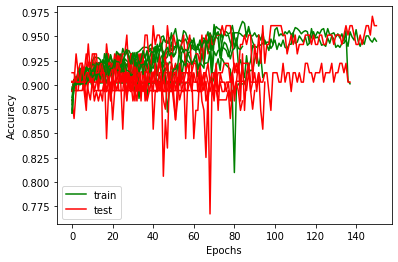

In [229]:
plot_accuracy(histories)

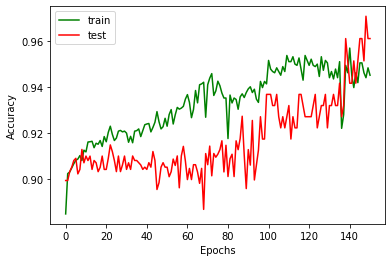

In [230]:
plot_mean_accuracy(histories)

In [231]:
mean_accuracy(histories)

Mean training accuracy:  0.9253153562545776
Mean test accuracy:  0.9052557945251465


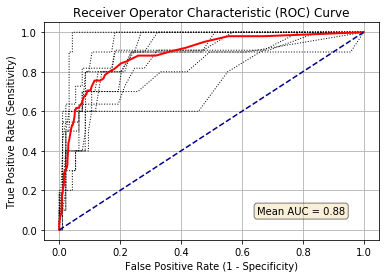

In [232]:
results = check_thresholds(X,y)

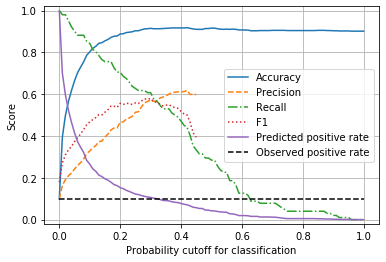

In [233]:
plot_thresholds(results)

In [234]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.3,0.32])])

    thresholds  accuracy  precision    recall        f1  \
30        0.30  0.914937   0.572664  0.607273  0.579855   
32        0.32  0.912985   0.567686  0.568182  0.560837   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
30                 0.106404                0.098637            0.607273   
32                 0.100607                0.098637            0.568182   

    false_positive_rate   roc_auc  
30             0.051464  0.879896  
32             0.049337  0.879896  


A probability threshold of about 0.32 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [235]:
threshold = 0.32

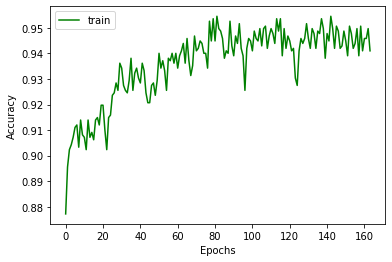

In [236]:
predictions = final_neural_network(X, y)

In [237]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       1          1
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [238]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_vehicle_crime.csv')

## Violence and sexual offences

In [239]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['violence_sexual'], bin_edges = pd.qcut(devon_cornwall['violence_sexual'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [240]:
# Have a look at counts
devon_cornwall['violence_sexual'].value_counts()

0    930
1    104
Name: violence_sexual, dtype: int64

In [241]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0       14.0     0
1      251.7     1

In [242]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['violence_sexual'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [243]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [244]:
histories = neural_net(X,y)


Fold number 1

Fold number 2

Fold number 3

Fold number 4

Fold number 5

Fold number 6

Fold number 7

Fold number 8

Fold number 9

Fold number 10


In [245]:
plot_accuracy(histories)

In [246]:
plot_mean_accuracy(histories)

In [247]:
mean_accuracy(histories)

Mean training accuracy:  0.9721656680107117
Mean test accuracy:  0.930358475446701


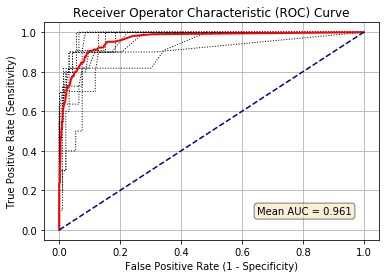

In [248]:
results = check_thresholds(X,y)

In [249]:
plot_thresholds(results)

In [250]:
# Show results for possible appropriate thresholds
print(results.loc[results['thresholds'].isin([0.36, 0.38])])

    thresholds  accuracy  precision  recall        f1  \
36        0.36  0.942000   0.716038    0.74  0.718412   
38        0.38  0.944875   0.736788    0.73  0.723987   

    predicted_positive_rate  observed_positive_rate  true_positive_rate  \
36                 0.106339                 0.10056                0.74   
38                 0.101522                 0.10056                0.73   

    false_positive_rate   roc_auc  
36             0.035484  0.960582  
38             0.031183  0.960582  


A probability threshold of about 0.38 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this into a final model:

In [251]:
threshold = 0.38

In [252]:
predictions = final_neural_network(X, y)

In [253]:
# Make table of LSOA code with actual and predicted label
predictions.insert(0,"lsoa_code", devon_cornwall_lsoa['lsoa_code'])
predictions

lsoa_code  actual  predicted
0     E01015023       1          1
1     E01015024       0          0
2     E01015025       0          0
3     E01015026       0          0
4     E01015027       0          0
...         ...     ...        ...
1029  E01033236       0          0
1030  E01033289       0          0
1031  E01033291       0          0
1032  E01033292       0          0
1033  E01033294       0          0

[1034 rows x 3 columns]

In [254]:
# Save dataframe to CSV file
predictions.to_csv('./predictions/nnclass_violence_sexual.csv')